In [107]:
#Importing all the required libraries
import numpy as np
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

In [2]:
#The path to the datasets
train_file = '../ass3_partb_data/train.csv'
test_file = '../ass3_partb_data/test.csv'

### Reading Data

In [3]:
#Loading the datasets using numpy
#The data is normalized by bringing it in a range of zero to one
s = time.time()
train_data = np.genfromtxt(train_file, delimiter=',')
train_y = train_data[:,-1]
train_x = train_data[:,:-1]/255
train_x, train_y = shuffle(train_x, train_y)
train_data = []

test_data = np.genfromtxt(test_file, delimiter=',')
test_y = test_data[:,-1]
test_x = test_data[:,:-1]/255
test_data = []

print("Time taken to load data", time.time()-s)

Time taken to load data 13.441364049911499


In [4]:
#A helper function that takes the values of Y and gives a 2D matrix with one-hot encoding
def hot_encoding(y, r):
    m = y.shape[0]
    ans = np.zeros((m,r))
    x = np.arange(m)
    ans[x, y.astype('int')] = 1
    return ans

In [5]:
#Converting Train and test labels to one hot enccoding
r = 26
train_y = hot_encoding(train_y, r)
test_y = hot_encoding(test_y, r)

In [6]:
#Sigmoid of a given value
#z should be np array
def sigmoid(z):
    return 1/(1+np.exp(-z))

#Sigmoid derivative of a value, given its sigmoid value
def sigmoid_der(z):
    return z*(1-z)

#Relu for a given value
def relu(z):
    return np.maximum(0,z)

# Relu derivative of a value, given its relu value
def relu_der(z):
    return (z>0)*np.ones(z.shape)

In [7]:
#A function that builts and initialises a given Neural Network Archtecture with random values
#It uses Xavier Initialisation
def init_rand_param(n, r, hidden_units):
    
    c = n
    param_list = []
    l = hidden_units.copy()
    l.append(r)
    
#     np.random.seed(0)
    for i in l:
        a = np.random.randn(i, c+1) * (np.sqrt(2/(c+1)))
        param_list.append(a)
        a = []
        c = i
    
    return param_list

#A function that builts a given Neural Network Architecture and sets all the values to zero.
def init_zero_param(n, r, hidden_units):
    
    c = n
    param_list = []
    l = hidden_units.copy()
    l.append(r)
    
    for i in l:
        param_list.append(np.zeros((i, c+1)))
        c = i
    
    return param_list

In [8]:
#A helper function for Forward pass of a neural network
#it takes X and theta and activation function to be applied at each layer
# It returns value obtained as output at each layer
def forward(x, theta_list, activation_hidden, activation_out):
    
    x = np.insert(x, 0, 1, axis=1)
    
    y_list = []
    
    n = len(theta_list)
    
    for i in range(n-1):
        theta = theta_list[i]
        x = activation_hidden(np.matmul(x, theta.T))
        y_list.append(x)
        x = np.insert(x, 0, 1, axis=1)
    
    theta = theta_list[n-1]
    x = activation_out(np.matmul(x, theta.T))
    y_list.append(x)
    
    return y_list

In [9]:
# A function that calculates the accuracy of a model for a dataset(x,y) with given parameters(Theta)
# It makes use of forward pass of neural network

def accuracy(x, y, theta_list, activation_hidden, activation_out):
    
    m = x.shape[0]
    
    x = np.insert(x, 0, 1, axis=1)
    
    n = len(theta_list)
    
    for i in range(n-1):
        theta = theta_list[i]
        x = activation_hidden(np.matmul(x, theta.T))
        x = np.insert(x, 0, 1, axis=1)
        
    theta = theta_list[n-1]
    x = activation_out(np.matmul(x, theta.T))
    
    pred = np.argmax(x, axis=1)
    actual = np.argmax(y, axis = 1)
    
    c = np.sum(pred == actual)
    return c, c/m

## PART A

In [93]:
# A function that trains the neural network with given set of parameters
# It uses the backpropogation Algorithm
# It also takes the threshold values to decide convergence
# The model is trained using mini batch Stochastic Gradient Algorithm(SGD)
def train_model(data_x, data_y, M, n, hidden_units, r, eta, activation_hidden, activation_out, 
                threshold = 1e-5, no_of_iterations = 10, adaptive=False, debug = False, max_epoch = 2500):
    
    #Initialise weights
    theta_list = init_rand_param(n, r, hidden_units)
    no_of_layers = len(theta_list)
    m = data_x.shape[0]
    original_eta = eta
    
    #What derivative to be used at each layer
    act_o_der = sigmoid_der
    act_h_der = sigmoid_der
    
    if(activation_out == relu):
        act_o_der = relu_der
        
    if(activation_hidden == relu):
        act_h_der = relu_der
    
    #Index of batches for SGD
    i = 0
    batches = []
    while(i<m):
        batches.append((i, i+M))
        i = i+M
    
    #Storing loss and accuracy and each iteration and epochs
    b = len(batches)
    J_theta = []
    accuracies = []
    iter_count = 0
    batch = 0
    
    #Costs, later used for deciding convergence
    prev_cost = 0
    cost = 0
    
    #Mini Batch SGD
    while(True):
        #The current batch for SGD
        start,end = batches[batch]
        x = data_x[start:end]
        y = data_y[start:end]
        
        #Stores the gradient value of all parameters for this mini batch
        grad = []
        
        #The forward pass step
        y_list = forward(x, theta_list, activation_hidden, activation_out)
        
        #Error based on the forward pass
        predicted_class = y_list[-1]
        err = np.sum(np.square(y - predicted_class))/(2*M)

        y_list.insert(0, x)
        y_list.reverse()
        
        #The back propagation step, starting from the output layer
        output_layer = y_list[0]
        delta = (y - output_layer)*act_o_der(output_layer)
        g = np.matmul(delta.T, np.insert(y_list[1], 0, 1, axis=1))/(M)
        grad.append(g*-1)
        
        #Backpropogation step for hidden layers, starting from the last hidden layer
        for j in range(1, len(y_list)-1):
            
            layer = act_h_der(y_list[j])
            
            thet = theta_list[no_of_layers - j]
            delta = (np.matmul(delta, thet[:,1:]))*layer
            
            g = np.matmul(delta.T, np.insert(y_list[j+1], 0, 1, axis=1))/(M)
            
            grad.append(g*-1)

        J_theta.append(err)
        cost += err
        
        #Subtracting gradient from the weights with appropriate learning rate
        grad.reverse()
        for c,g in enumerate(grad):
            theta_list[c] = theta_list[c] - (eta)*g
            
        iter_count += 1
        batch = (batch+1)%b
        
        #when one epoch is completed
        if(batch==0):
            count, acc = accuracy(train_x, train_y, theta_list, activation_hidden, activation_out)
            epoch = (iter_count+1)//b
            
            if(debug):
                print("Epoch:", epoch,"| Loss:", J_theta[-1], "Accuracy:", acc, count, eta)
            
            accuracies.append(acc)
            cost = cost/b
            
            #Convergence of loss
            if(abs(cost-prev_cost) < threshold):
                print("Loss threshold triggered")
                break
            
            #Convergence when maximum epochs are reached
            if(epoch >= max_epoch):
                print("Max epochs reached")
                break
                
            prev = accuracies[-(no_of_iterations+1):-1]
            prev = sum(prev)/no_of_iterations
            
            #Convergence if accuracies are not updating
            if(abs(accuracies[-1] - prev) < 1e-5):
                print("Accuracy threshold triggered")
                break
                
            prev_cost = cost
            
            #Decrease learning rate if adaptive is set to true
            if(adaptive == True):
                if(eta>0.05 or activation_hidden == relu):
                    eta = original_eta/(np.sqrt(epoch+1))
                elif(eta>0.015):
                    eta = eta - threshold/10
        
    return theta_list, J_theta, accuracies

## PART B

In [30]:
#Training different models with constant learning rate of 0.1, and appropriate threshold for convergence
#The number of units in hidden layer varies
hidden_layer_units = [1, 5, 10, 50, 100]
eta = 0.1
M = 100
n = train_x.shape[1]
r = train_y.shape[1]
threshold = 4e-5
no_of_iterations = 15

train_accuracies_b = []
test_accuracies_b = []
time_taken_b = []
accuracies_b = []
loss_b = []

for h in hidden_layer_units:
    
    print("Going for h:", h)
    s = time.time()
    theta_learnt, loss, acc = train_model(train_x, train_y, M, n, [h], r, eta, sigmoid, sigmoid,
                                          threshold, no_of_iterations)
    e = time.time() - s
    
    time_taken_b.append(e)
    accuracies_b.append(acc)
    loss_b.append(loss)
    
    count, train_acc = accuracy(train_x, train_y, theta_learnt, sigmoid, sigmoid)
    train_accuracies_b.append(train_acc)
    
    count, test_acc = accuracy(test_x, test_y, theta_learnt, sigmoid, sigmoid)
    test_accuracies_b.append(test_acc)
    
    print("Epoch taken:", len(acc), "||Accuracies:", train_acc, test_acc, "||Time taken:", e)

Going for h: 1
Accuracy threshold triggered
Epoch taken: 42 ||Accuracies: 0.07638461538461538 0.07692307692307693 ||Time taken: 3.1818652153015137
Going for h: 5
Accuracy threshold triggered
Epoch taken: 460 ||Accuracies: 0.261 0.2609230769230769 ||Time taken: 43.99122738838196
Going for h: 10
Accuracy threshold triggered
Epoch taken: 999 ||Accuracies: 0.8116923076923077 0.7576923076923077 ||Time taken: 103.5424633026123
Going for h: 50
Loss threshold triggered
Epoch taken: 907 ||Accuracies: 0.9385384615384615 0.8844615384615384 ||Time taken: 145.51761770248413
Going for h: 100
Accuracy threshold triggered
Epoch taken: 918 ||Accuracies: 0.9559230769230769 0.9 ||Time taken: 198.85500144958496


In [48]:
#The results obtained for constant learning rate
print("Train", train_accuracies_b)
print("Test", test_accuracies_b)
print("Time", time_taken_b)

Train [0.07638461538461538, 0.261, 0.8116923076923077, 0.9385384615384615, 0.9559230769230769]
Test [0.07692307692307693, 0.2609230769230769, 0.7576923076923077, 0.8844615384615384, 0.9]
Time [3.1818652153015137, 43.99122738838196, 103.5424633026123, 145.51761770248413, 198.85500144958496]


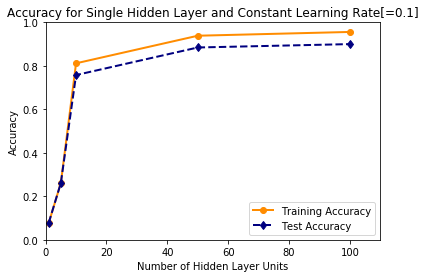

In [44]:
#Plotting the required results of accuracy as hidden units are varied in constant learning rate
plt.figure()
lw=2
plt.plot(hidden_layer_units, train_accuracies_b, color='darkorange', lw=lw, label='Training Accuracy', marker='o')
plt.plot(hidden_layer_units, test_accuracies_b, color='navy', lw=lw, linestyle='--', label='Test Accuracy', marker='d')
plt.xlim([0, 110])
plt.ylim([0.0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of Hidden Layer Units')
plt.title('Accuracy for Single Hidden Layer and Constant Learning Rate[=0.1]')
plt.legend(loc="lower right")
plt.show()

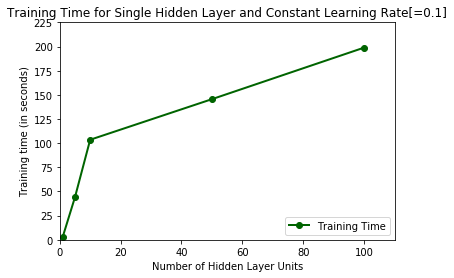

In [49]:
#Plotting the required results of training time as hidden units are varied in constant learnig rate
plt.figure()
lw=2
plt.plot(hidden_layer_units, time_taken_b, color='darkgreen', lw=lw, label='Training Time', marker='o')
plt.xlim([0, 110])
plt.ylim([0, 225])
plt.ylabel('Training time (in seconds)')
plt.xlabel('Number of Hidden Layer Units')
plt.title('Training Time for Single Hidden Layer and Constant Learning Rate[=0.1]')
plt.legend(loc="lower right")
plt.show()

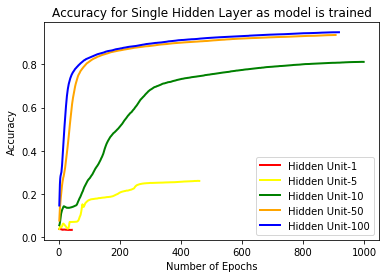

In [34]:
#Plotting how accuracy grows as model is learnt for constant learning rate
m = train_x.shape[0]
plt.figure()
colors = ['red', 'yellow', 'green', 'orange', 'blue']

for i,h in enumerate(hidden_layer_units):
    
    acc = accuracies_b[i]
    acc_x = np.arange(1, len(acc)+1)
    
    lw=2
    label = 'Hidden Unit-' + str(h)
    plt.plot(acc_x, acc, color=colors[i], lw=lw, label=label)

plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Accuracy for Single Hidden Layer as model is trained')
plt.legend(loc="lower right")
plt.show()

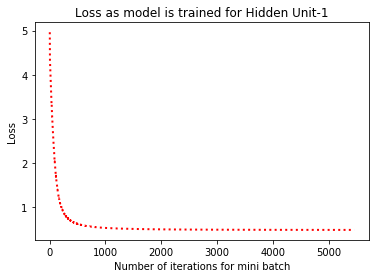

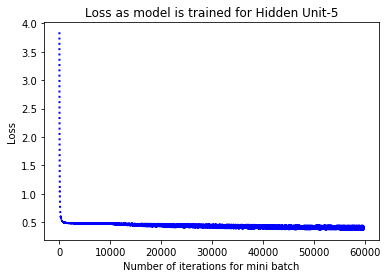

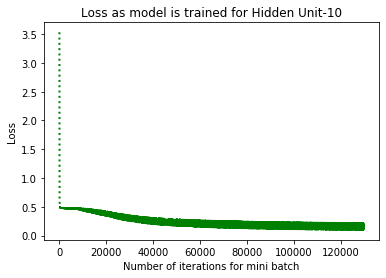

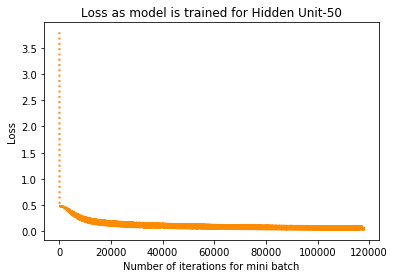

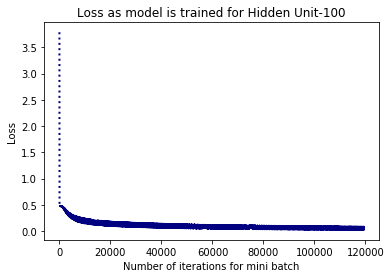

In [35]:
#Plotting how loss decreases as model is learnt for constant learning rate 
m = train_x.shape[0]
colors = ['red', 'blue', 'green', 'darkorange', 'navy']

for i,h in enumerate(hidden_layer_units):
    
    plt.figure()
    loss = loss_b[i]
    loss_x = np.arange(1, len(loss)+1 )
    
    lw=2
    title = 'Loss as model is trained for Hidden Unit-' + str(h)
    plt.ylabel('Loss')
    plt.xlabel('Number of iterations for mini batch')
    plt.title(title)
    
    plt.plot(loss_x, loss, color=colors[i], lw=lw, linestyle='dotted')

    plt.show()

## PART C

In [19]:
#Training different models with adaptive learning rate initialized with 0.5
# Appropriate threshold for convergence is chosen
#The number of units in hidden layer varies

hidden_layer_units = [1, 5, 10, 50, 100]
eta = 0.5
M = 100
n = train_x.shape[1]
r = train_y.shape[1]
threshold = 4e-5
no_of_iterations = 15

train_accuracies_c = []
test_accuracies_c = []
time_taken_c = []
accuracies_c = []
loss_c = []

for h in hidden_layer_units:
    
    print("Going for h:", h)
    s = time.time()
    theta_learnt, loss, acc = train_model(train_x, train_y, M, n, [h], r, eta, sigmoid, sigmoid,
                                          threshold, no_of_iterations, True)
    e = time.time() - s
    
    time_taken_c.append(e)
    accuracies_c.append(acc)
    loss_c.append(loss)
    
    count, train_acc = accuracy(train_x, train_y, theta_learnt, sigmoid, sigmoid)
    train_accuracies_c.append(train_acc)
    
    count, test_acc = accuracy(test_x, test_y, theta_learnt, sigmoid, sigmoid)
    test_accuracies_c.append(test_acc)
    
    print("Epoch taken:", len(acc), "||Accuracies:", train_acc, test_acc, "||Time taken:", e)

Going for h: 1
Accuracy threshold triggered
Epoch taken: 19 ||Accuracies: 0.057692307692307696 0.05553846153846154 ||Time taken: 1.54701828956604
Going for h: 5
Accuracy threshold triggered
Epoch taken: 73 ||Accuracies: 0.14084615384615384 0.142 ||Time taken: 6.192809104919434
Going for h: 10
Accuracy threshold triggered
Epoch taken: 1413 ||Accuracies: 0.7963846153846154 0.7535384615384615 ||Time taken: 145.6972131729126
Going for h: 50
Loss threshold triggered
Epoch taken: 964 ||Accuracies: 0.9133846153846154 0.87 ||Time taken: 158.9687316417694
Going for h: 100
Loss threshold triggered
Epoch taken: 1028 ||Accuracies: 0.9275384615384615 0.8827692307692308 ||Time taken: 220.72284698486328


In [101]:
#The results obtained for adaptive learning rate
print("Train", train_accuracies_c)
print("Test", test_accuracies_c)
print("Time", time_taken_c)

Train [0.057692307692307696, 0.14084615384615384, 0.7963846153846154, 0.9133846153846154, 0.9275384615384615]
Test [0.05553846153846154, 0.142, 0.7535384615384615, 0.87, 0.8827692307692308]
Time [1.54701828956604, 6.192809104919434, 145.6972131729126, 158.9687316417694, 220.72284698486328]


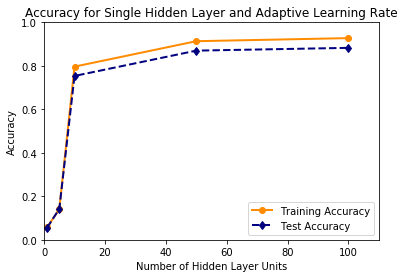

In [104]:
#Plotting the required results of accuracy as hidden units are varied in adaptive learning rate
plt.figure()
lw=2
plt.plot(hidden_layer_units, train_accuracies_c, color='darkorange', lw=lw, label='Training Accuracy', marker='o')
plt.plot(hidden_layer_units, test_accuracies_c, color='navy', lw=lw, linestyle='--', label='Test Accuracy', marker='d')
plt.xlim([0, 110])
plt.ylim([0.0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of Hidden Layer Units')
plt.title('Accuracy for Single Hidden Layer and Adaptive Learning Rate')
plt.legend(loc="lower right")
plt.show()

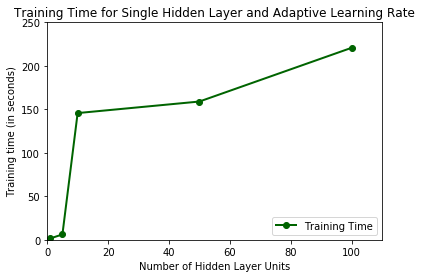

In [105]:
#Plotting the required results of training time as hidden units are varied in adaptive learnig rate
plt.figure()
lw=2
plt.plot(hidden_layer_units, time_taken_c, color='darkgreen', lw=lw, label='Training Time', marker='o')
plt.xlim([0, 110])
plt.ylim([0, 250])
plt.ylabel('Training time (in seconds)')
plt.xlabel('Number of Hidden Layer Units')
plt.title('Training Time for Single Hidden Layer and Adaptive Learning Rate')
plt.legend(loc="lower right")
plt.show()

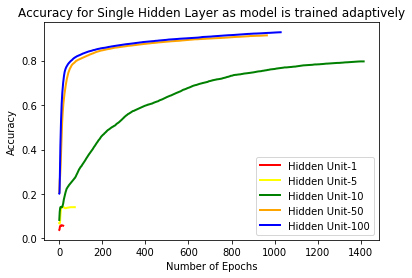

In [32]:
#Plotting how accuracy grows as model is learnt for adaptive learning rate
m = train_x.shape[0]
plt.figure()
colors = ['red', 'yellow', 'green', 'orange', 'blue']

for i,h in enumerate(hidden_layer_units):
    
    acc = accuracies_c[i]
    acc_x = np.arange(1, len(acc)+1)
    
    lw=2
    label = 'Hidden Unit-' + str(h)
    plt.plot(acc_x, acc, color=colors[i], lw=lw, label=label)

plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Accuracy for Single Hidden Layer as model is trained adaptively')
plt.legend(loc="lower right")
plt.show()

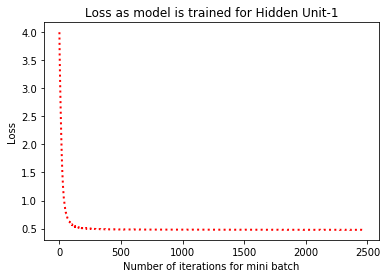

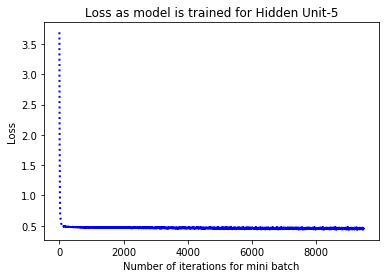

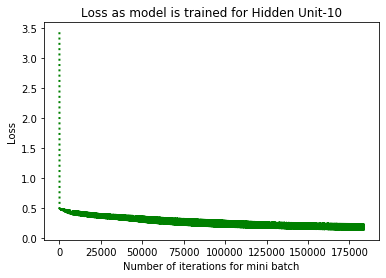

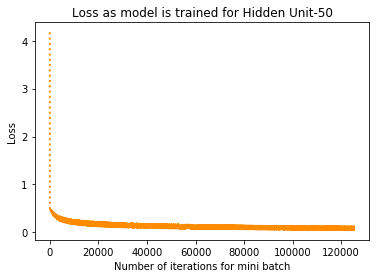

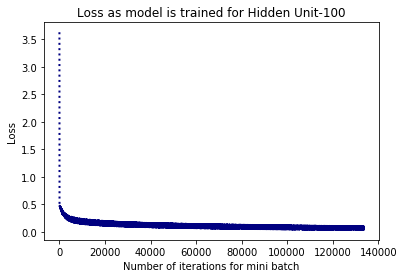

In [33]:
#Plotting how loss decreases as model is learnt for adaptive learning rate
m = train_x.shape[0]
colors = ['red', 'blue', 'green', 'darkorange', 'navy']

for i,h in enumerate(hidden_layer_units):
    
    plt.figure()
    loss = loss_c[i]
    loss_x = np.arange(1, len(loss)+1 )
    
    lw=2
    title = 'Loss as model is trained for Hidden Unit-' + str(h)
    plt.ylabel('Loss')
    plt.xlabel('Number of iterations for mini batch')
    plt.title(title)
    
    plt.plot(loss_x, loss, color=colors[i], lw=lw, linestyle='dotted')

    plt.show()

## PART D

In [90]:
#Relu activation units in hidden layer and Sigmoid activation units in output layer
#Two hidden layer models with 100 units in each layer
#Training the model with adaptive learning rate initialized with 0.5
#Appropriate threshold for convergence is chosen

hidden_layer_units = [100, 100]
eta = 0.5
M = 100
n = train_x.shape[1]
r = train_y.shape[1]
threshold = 4e-5
no_of_iterations = 15

print("Going for relu hidden-[100,100]")
s = time.time()
theta_learnt, loss, acc = train_model(train_x, train_y, M, n, hidden_layer_units, r, eta, relu, sigmoid,
                                          threshold, no_of_iterations, True)
e = time.time() - s

count, train_acc = accuracy(train_x, train_y, theta_learnt, relu, sigmoid)
count, test_acc = accuracy(test_x, test_y, theta_learnt, relu, sigmoid)

print("Epoch taken:", len(acc), "||Accuracies:", train_acc, test_acc, "||Time taken:", e)

Going for relu hidden-[100,100]
Loss threshold triggered
Epoch taken: 297 ||Accuracies: 0.9603076923076923 0.9078461538461539 ||Time taken: 101.6949028968811


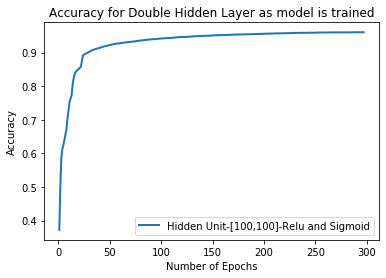

In [91]:
#Plotting how accuracy grows as model is learnt with relu activation unit in hidden layers
plt.figure()

acc_x = np.arange(1, len(acc)+1)

lw=2
label = 'Hidden Unit-[100,100]-Relu and Sigmoid'
plt.plot(acc_x, acc, lw=lw, label=label)

plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Accuracy for Double Hidden Layer as model is trained')
plt.legend(loc="lower right")
plt.show()

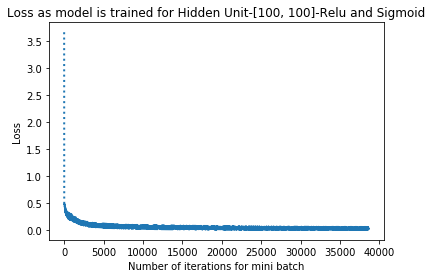

In [92]:
#Plotting how loss decreases as model is learnt with relu activation unit in hidden layers
plt.figure()
loss_x = np.arange(1, len(loss)+1 )

lw=2
title = 'Loss as model is trained for Hidden Unit-[100, 100]-Relu and Sigmoid'
plt.ylabel('Loss')
plt.xlabel('Number of iterations for mini batch')
plt.title(title)

plt.plot(loss_x, loss, lw=lw, linestyle='dotted')

plt.show()

In [74]:
#Sigmoid activation units in hidden layer and Sigmoid activation units in output layer as well
#Two hidden layer models with 100 units in each layer
#Training the model with adaptive learning rate initialized with 0.5
#Appropriate threshold for convergence is chosen

hidden_layer_units = [100, 100]
eta = 0.5
M = 100
n = train_x.shape[1]
r = train_y.shape[1]
threshold = 4e-5
no_of_iterations = 15

print("Going for Sigmoid hidden-[100,100]")
s = time.time()
theta_learnt, loss, acc = train_model(train_x, train_y, M, n, hidden_layer_units, r, eta, sigmoid, sigmoid,
                                          threshold, no_of_iterations, True)
e = time.time() - s

count, train_acc = accuracy(train_x, train_y, theta_learnt, sigmoid, sigmoid)
count, test_acc = accuracy(test_x, test_y, theta_learnt, sigmoid, sigmoid)

print("Epoch taken:", len(acc), "||Accuracies:", train_acc, test_acc, "||Time taken:", e)

Going for Sigmoid hidden-[100,100]
Loss threshold triggered
Epoch taken: 1296 ||Accuracies: 0.929923076923077 0.8872307692307693 ||Time taken: 319.3763129711151


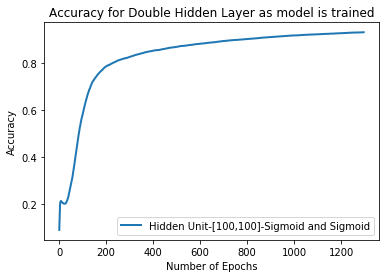

In [77]:
#Plotting how accuracy grows as model is learnt with sigmoid activation unit in hidden layers
plt.figure()

acc_x = np.arange(1, len(acc)+1)

lw=2
label = 'Hidden Unit-[100,100]-Sigmoid and Sigmoid'
plt.plot(acc_x, acc, lw=lw, label=label)

plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Accuracy for Double Hidden Layer as model is trained')
plt.legend(loc="lower right")
plt.show()

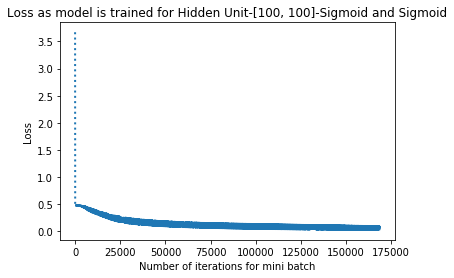

In [78]:
#Plotting how loss decreases as model is learnt with sigmoid activation unit in hidden layers

plt.figure()
loss_x = np.arange(1, len(loss)+1 )

lw=2
title = 'Loss as model is trained for Hidden Unit-[100, 100]-Sigmoid and Sigmoid'
plt.ylabel('Loss')
plt.xlabel('Number of iterations for mini batch')
plt.title(title)

plt.plot(loss_x, loss, lw=lw, linestyle='dotted')

plt.show()

## PART E

In [173]:
#Scikit learn's MLP Classifier for two hidden layered neural network with relu activation units in 
#Hidden layer, similar to that in part(d), adaptive learning rate is used
clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                    batch_size=100, learning_rate='adaptive', max_iter=1500)

In [174]:
#A function to calculate accuracy based on probabilities given by the sklearn's learnt model
#The class with highest probability is predicted and the corresponding accuracy is being reported

def accuracy_mlp(x, y, clf):
    
    m = x.shape[0]
    
    pred = clf.predict_proba(x)
    pred = np.argmax(pred, axis = 1)
    
    actual = np.argmax(y, axis = 1)
    
    c = np.sum(pred == actual)
    return c/m

In [213]:
#Scikit learn's MLP Classifier for two hidden layered neural network with relu activation units in 
#Hidden layer, similar to that in part(d), adaptive learning rate is used
clf2 = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                    batch_size=100, learning_rate='adaptive', 
                    learning_rate_init=0.1, max_iter=1500)

s = time.time()
clf2.fit(train_x, train_y)
print("Time taken:", time.time()-s)

print("Classes:", clf2.classes_)
print("Epochs:", clf2.n_iter_)
print("Number of classes in output layer:", clf2.n_outputs_)
print("Activation function in output layer:", clf2.out_activation_)
print("Final Loss:", clf2.loss_)

print("Training accuracy:", accuracy_mlp(train_x, train_y,clf2)*100,"%")
print("Test accuracy:", accuracy_mlp(test_x, test_y, clf2)*100,"%")

Time taken: 46.70655655860901
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Epochs: 152
Number of classes in output layer: 26
Activation function in output layer: logistic
Final Loss: 0.00407508232310497
Training accuracy: 100.0 %
Test accuracy: 92.18461538461538 %
